1. Set up a data science project structure in a new git repository in your
GitHub account
2. Download the product demand data set from
https://www.kaggle.com/felixzhao/productdemandforecasting
3. Load the data set into panda data frames
4. Formulate one or two ideas on how feature engineering would help the
data set to establish additional value using exploratory data analysis
5. Build one or more forecasting models to determine the demand for a
particular product using the other columns as features
6. Document your process and results
7. Commit your notebook, source code, visualizations and other
supporting files to the git repository in GitHub

### Data Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

In [2]:
# Reads a .csv as pandas dataframe.
df = pd.read_csv('Historical Product Demand.csv')
df.head()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012/7/27,100
1,Product_0979,Whse_J,Category_028,2012/1/19,500
2,Product_0979,Whse_J,Category_028,2012/2/3,500
3,Product_0979,Whse_J,Category_028,2012/2/9,500
4,Product_0979,Whse_J,Category_028,2012/3/2,500


Let's check for missing values. From the figure below, we see that that are missing dates. We will drop these records.

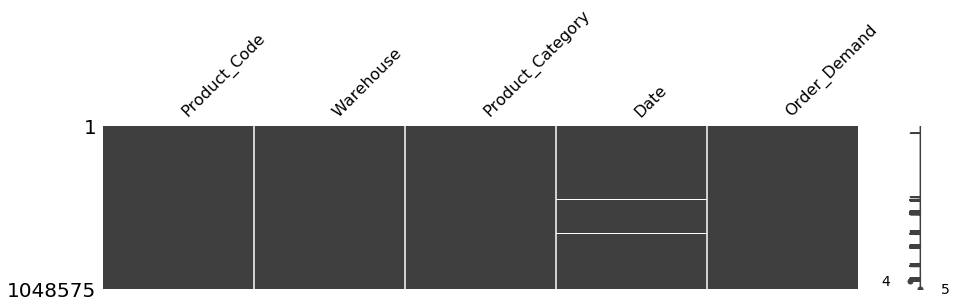

In [3]:
msno.matrix(df, figsize=(15, 3));

In [4]:
# Some data in 'Order_Demand' are not numerical. 
# Let's get rid of those errors.
df = df[pd.to_numeric(df['Order_Demand'], errors='coerce').notnull()]

In [5]:
# Let's drop nan values.
df.dropna(inplace=True)

In [6]:
df = df.sort_values('Date')
df.head()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
44799,Product_0965,Whse_A,Category_006,2011/1/8,2
75193,Product_0642,Whse_C,Category_019,2011/10/31,3
44795,Product_0965,Whse_A,Category_006,2011/11/18,1
44450,Product_0980,Whse_A,Category_028,2011/11/18,4000
44796,Product_0965,Whse_A,Category_006,2011/11/21,3


In [7]:
# Data types conversion.
df['Date'] = pd.to_datetime(df['Date'])
df['Order_Demand'] = pd.to_numeric(df['Order_Demand'])

Now the data looks as expected:

In [8]:
df.dtypes

Product_Code                object
Warehouse                   object
Product_Category            object
Date                datetime64[ns]
Order_Demand                 int64
dtype: object

### Features

Since we are dealing with time series data, let's create some features related to this kind of data. This will help in the exploratory analysis, where we want to check if there is a relation between the target variable (`Order_Demand`) with some features such as the day of the week and the month of the year, for instance.

In [9]:
df['dayofweek'] = df['Date'].dt.dayofweek
df['quarter'] = df['Date'].dt.quarter
df['month'] = df['Date'].dt.month
df['year'] = df['Date'].dt.year
df['dayofyear'] = df['Date'].dt.dayofyear
df['dayofmonth'] = df['Date'].dt.day
df['weekofyear'] = df['Date'].dt.weekofyear

### Exploradory Data Analysis

In [10]:
df.columns

Index(['Product_Code', 'Warehouse', 'Product_Category', 'Date', 'Order_Demand',
       'dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'dayofmonth',
       'weekofyear'],
      dtype='object')

In [11]:
print("Number of unique products:", df['Product_Code'].nunique())

Number of unique products: 2160


In [12]:
print("Number of unique product categories:", df['Product_Category'].nunique())

Number of unique product categories: 33


In [13]:
print("Number of unique warehouses:", df['Warehouse'].nunique())

Number of unique warehouses: 4


Let's check the distribution of the target variable:

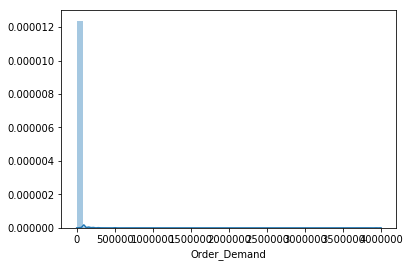

In [14]:
sns.distplot(df['Order_Demand']);

The plot above shows that the range of the target variable is too broad. Too make our lives easier, we'll make a logarithm transformation on this variable.

In [15]:
df['Order_Demand'] = np.log1p(df['Order_Demand'])

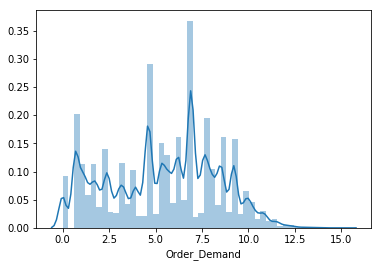

In [16]:
sns.distplot(df['Order_Demand']);

Now, let's create a simple correlation matrix to analyse how our features correlate to each other.

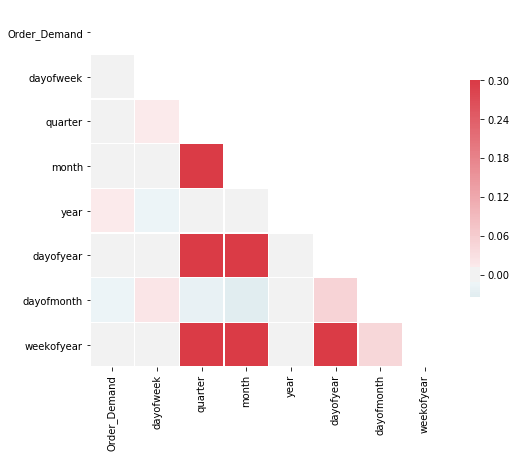

In [17]:
corr = df.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(8,8))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

From this matrix, we can see that there are high correlation between timely features, as expected. However, there seems to be no strong correlation between our target variable and our features. Notwithstanding, we can see that there are some positive correlation between the year and the target variable. This means that, as the years go by, more products, in general, are being ordered.

The next plot shows the order demand by month, highlighting each warehouse. From that, we see that `Whse_J` order many more products than any other warehouse. Considering our universe of 4 warehouses, it is an outlier.

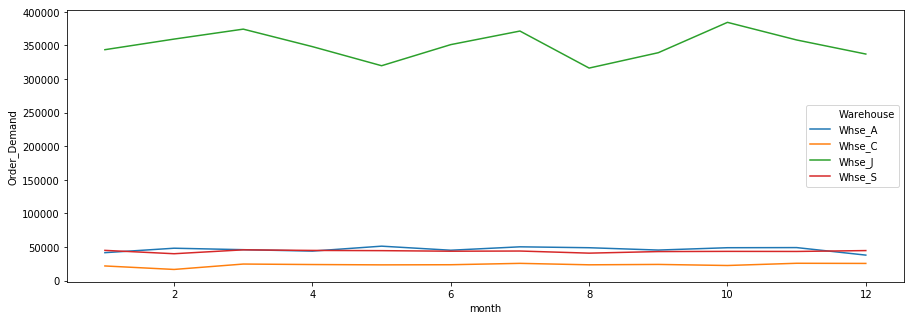

In [18]:
g = df.groupby(['Warehouse', 'month'])['Order_Demand'].sum().reset_index()
plt.figure(figsize=(15, 5))
sns.lineplot(x='month', y='Order_Demand', data=g, hue='Warehouse');

Looking at the product categories, we see that the most ordered on is `Category_019`. We will analyze this category in more detail.

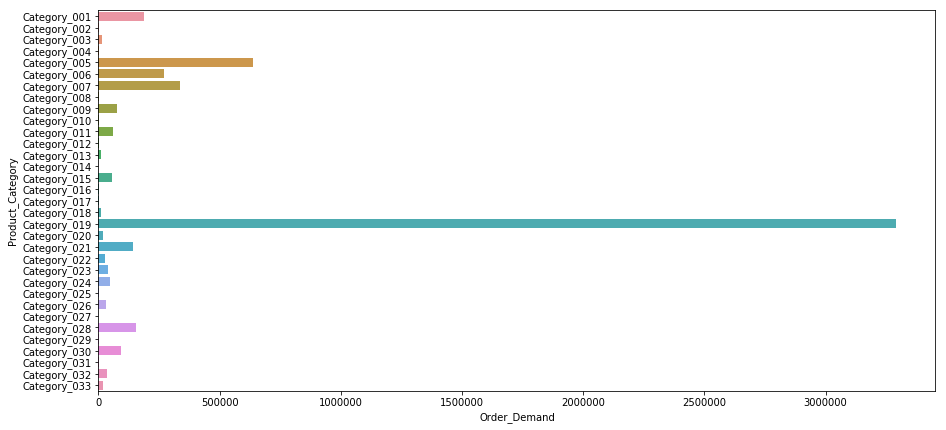

In [19]:
g = df.groupby('Product_Category')['Order_Demand'].sum().reset_index()
plt.figure(figsize=(15, 7))
sns.barplot(y='Product_Category', x='Order_Demand', data=g);

Again, the warehouse that orders the majority of the products in this category is `Whse_j`. Also, the order demand seems to present some seasonality.

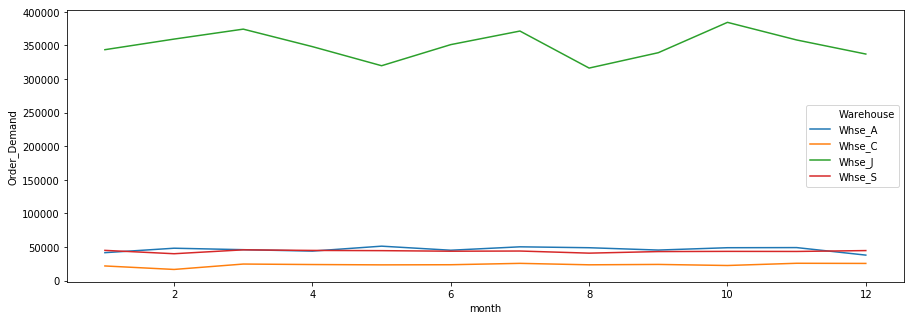

In [20]:
g = df[df['Product_Category'] == 'Category_019']
g = df.groupby(['Warehouse', 'month'])['Order_Demand'].sum().reset_index()
plt.figure(figsize=(15, 5))
sns.lineplot(x='month', y='Order_Demand', data=g, hue='Warehouse');

Analysing the order demands per year, we can note that there was increase from 2011 to 2014. From 2014, the demand seems to be decreasing. We disconsider 2017 here, because the big decrease in 2017 might just imply that there is no data for the whole year.

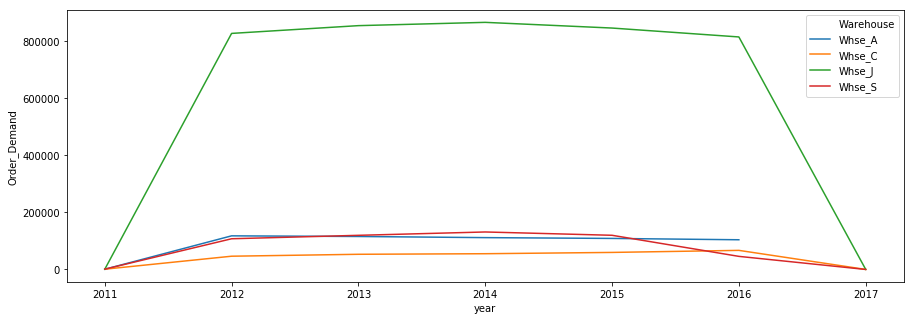

In [21]:
g = df.groupby(['Warehouse', 'year'])['Order_Demand'].sum().reset_index()
plt.figure(figsize=(15, 5))
sns.lineplot(x='year', y='Order_Demand', data=g, hue='Warehouse');

If we take a look in quaterly data, we see that in the first and last quarters of the month, the order demand is a little bit higher then in the second and third.

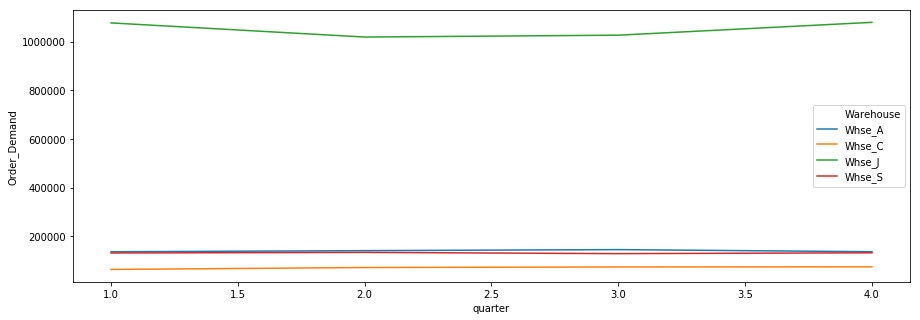

In [22]:
g = df.groupby(['Warehouse', 'quarter'])['Order_Demand'].sum().reset_index()
plt.figure(figsize=(15, 5))
sns.lineplot(x='quarter', y='Order_Demand', data=g, hue='Warehouse');

Finally, taking a look at the order demand per week of the year, we see a higher variation and possible seasonality.

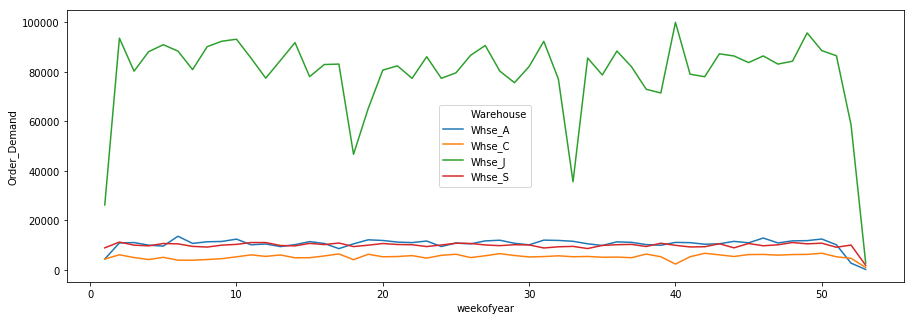

In [23]:
g = df.groupby(['Warehouse', 'weekofyear'])['Order_Demand'].sum().reset_index()
plt.figure(figsize=(15, 5))
sns.lineplot(x='weekofyear', y='Order_Demand', data=g, hue='Warehouse');

Now, let's take a look into the products demands.

In [24]:
g = df.groupby('Product_Code')['Order_Demand'].sum()
g.sort_values(ascending=False)

Product_Code
Product_1359    152921.977611
Product_1295     88382.042627
Product_1378     79600.247603
Product_1286     73758.810252
Product_1382     72307.749721
Product_1453     69322.227590
Product_1294     68032.105456
Product_1287     64953.812946
Product_1377     62589.321309
Product_1274     60701.888261
Product_1248     58376.866605
Product_1241     47590.104738
Product_1451     42104.985546
Product_1360     40964.326541
Product_1456     40636.060568
Product_1016     38287.700988
Product_1264     37030.774607
Product_0033     35989.929272
Product_1381     35433.943905
Product_1350     35088.858230
Product_1452     34147.382406
Product_1410     31178.954542
Product_1262     31050.022780
Product_1463     30477.565494
Product_1470     30448.394853
Product_1250     29564.659729
Product_0031     29473.503901
Product_1512     29267.945133
Product_1970     28372.113575
Product_1554     27625.747213
                    ...      
Product_1697        24.783399
Product_0237        24.4741

We can see that the most ordered product is Product_1359. Let's take a look into it.

The plot below shows the demand of this product per day of week (0: Sunday). We can see that the demand starts on Sunday and lasts until Thursday. To proper understand this behavior, we have to get more information about the products.

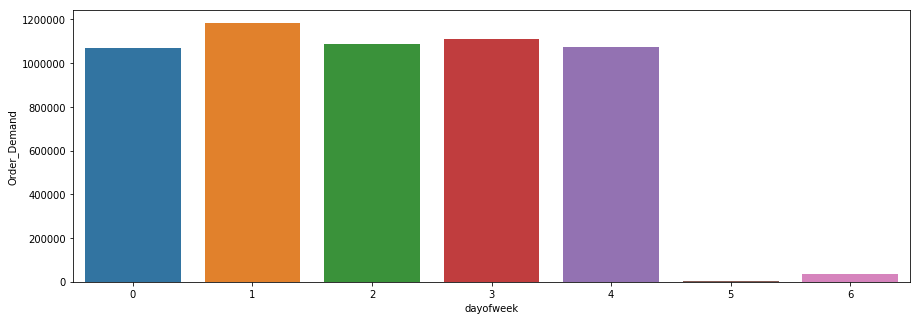

In [25]:
g = df[df['Product_Code'] == 'Product_1359']
g = df.groupby(['dayofweek'])['Order_Demand'].sum().reset_index()
plt.figure(figsize=(15, 5))
sns.barplot(x='dayofweek', y='Order_Demand', data=g);

Here, we see the variation of the order demand of this product per day of the month. We can also observe some variation. This shows that the generated features might be useful for prediction purposes.

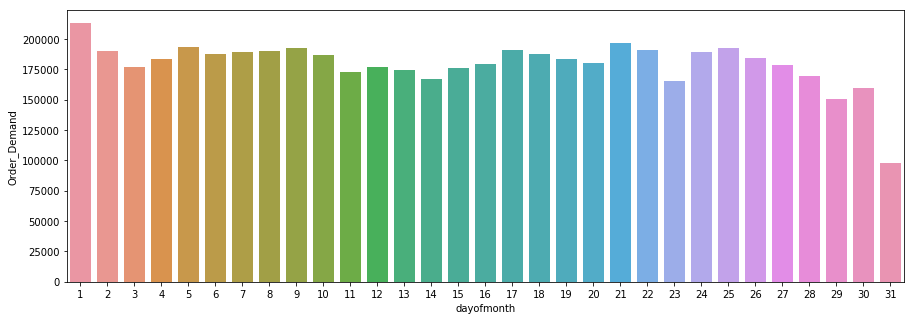

In [26]:
g = df.groupby(['dayofmonth'])['Order_Demand'].sum().reset_index()
plt.figure(figsize=(15, 5))
sns.barplot(x='dayofmonth', y='Order_Demand', data=g);

Now, we have the order demand of this product per month. The peak happens in October

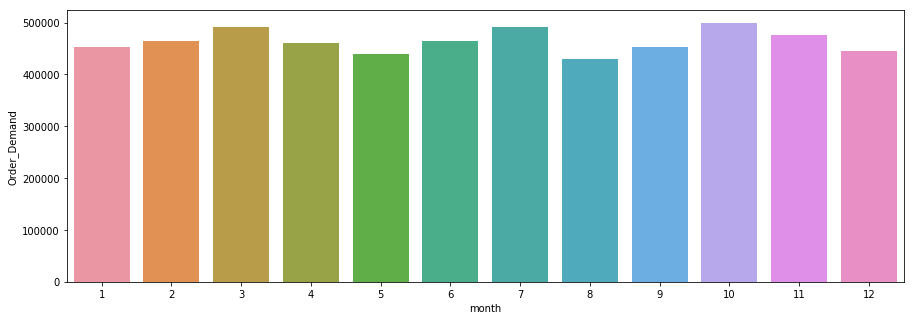

In [27]:
g = df.groupby(['month'])['Order_Demand'].sum().reset_index()
plt.figure(figsize=(15, 5))
sns.barplot(x='month', y='Order_Demand', data=g);

The yearly order demand for this product behaves as the general order demand behavior. This is expected, since the plot below shows the most ordered product.

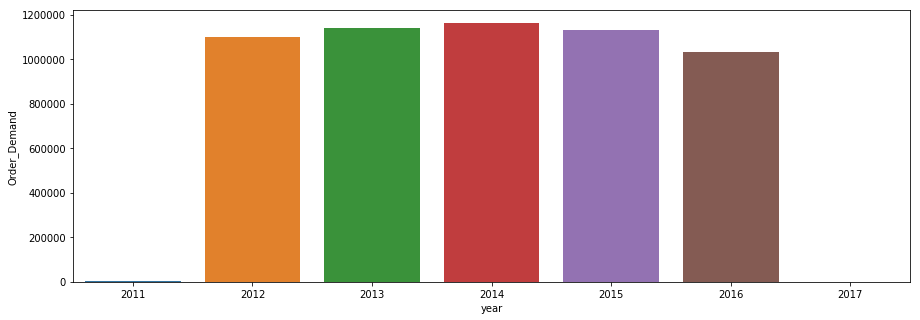

In [28]:
g = df.groupby(['year'])['Order_Demand'].sum().reset_index()
plt.figure(figsize=(15, 5))
sns.barplot(x='year', y='Order_Demand', data=g);

Analazying its order demand per quarter of the year, we don't see many varation. We may discard this feature for training.

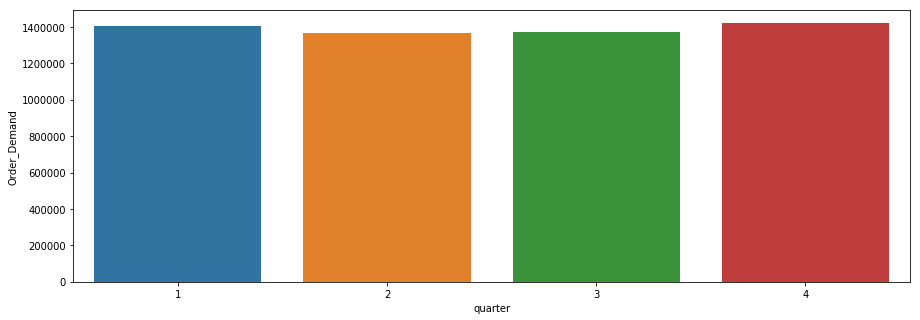

In [29]:
g = df.groupby(['quarter'])['Order_Demand'].sum().reset_index()
plt.figure(figsize=(15, 5))
sns.barplot(x='quarter', y='Order_Demand', data=g);

Finally, there is a variation in the order demand of this product according to the week of the year.

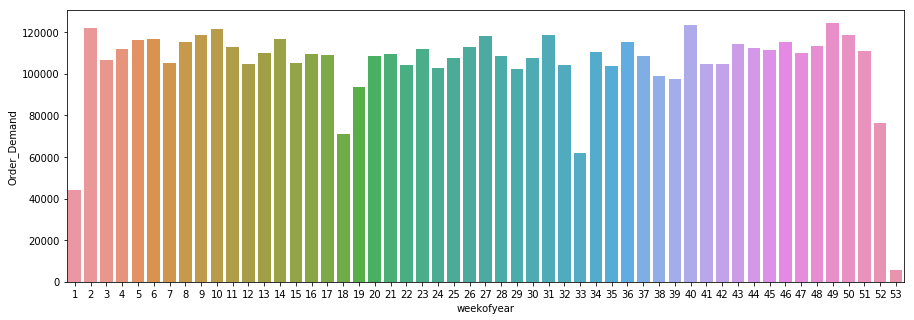

In [30]:
g = df.groupby(['weekofyear'])['Order_Demand'].sum().reset_index()
plt.figure(figsize=(15, 5))
sns.barplot(x='weekofyear', y='Order_Demand', data=g);

### Modeling

We are going to train models to predict the order demand for `Product_1359`.

In [31]:
df.columns

Index(['Product_Code', 'Warehouse', 'Product_Category', 'Date', 'Order_Demand',
       'dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'dayofmonth',
       'weekofyear'],
      dtype='object')

According to what was observed during the exploratory analysis, we will use the following features for training:

In [32]:
df = df[df['Product_Code'] == 'Product_1359']
cols = ['Date', 'Warehouse', 'Order_Demand',
        'dayofweek', 'month', 'year', 'dayofmonth', 'weekofyear']
df = df[cols]

As the majority of the Python packages does not support categorical featuers, we have to convert them to numerical.
We can do this using `LabelEncoder`.

In [33]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(df['Warehouse'])
df['Warehouse'] = le.transform(df['Warehouse'] )

Here we separate our features from out target variable.

In [34]:
x = df.drop(['Order_Demand', 'Date'], axis=1).copy()
y = df['Order_Demand'].copy()

Let's define a performance metric. We are going to use the root mean squared error (RMSE), which is often used in regression problems. The advantage of the RMSE is that is keeps the error in the same order as the target variable, which helps in the task of analyzing the model performance. 

In [35]:
def root_mean_squared_error(y_true, y_pred):
    """Calculates RMSE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return ((y_true - y_pred) ** 2).mean() ** .5

In [36]:
df['Order_Demand'].min(), df['Order_Demand'].max()

(0.0, 14.508658238524095)

#### XGB Regressor

First, let's train a simple XGB Regressor. It will use all selected features to predict the order demand for a given warehouse, day of month, day of week, month, week of year and year.

Let's split the data in train / test sets.

In [37]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

Here, we are modeling using XGB default parameters. To improve our results and capture the most of the data, we should fine tune the model parameters using something as `GridSearch`, from `Sklearn`.

In [38]:
import xgboost as xgb

model = xgb.XGBRegressor(seed=0)
model.fit(X_train, y_train)
print(model)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[09:25:19] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0, silent=None,
       subsample=1, verbosity=1)


In [39]:
y_pred = model.predict(X_test)
rmse = root_mean_squared_error(y_test, y_pred)

print(f'RMSE : {rmse:.2f}')

RMSE : 1.57


This simple model results in a RMSE of 1.57. Remember that the target value varies from 0 to 14.5 (1.57/14.5 = 0.10%). Hence, with a simple model, we were able to achieve a good result. 

#### Facebook Prophet

Now, let's try a more complex model: "Facebook Prophet". It is a powerful model that takes care of a lot of things automatically. According to the docs:

> Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.

As a time series model, it expects just the date time value and its correspondent target variable. We don't have to worry with missing data or shifts in the data (which happens in this data set).

In [52]:
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric

Let's check the date range:

In [53]:
df['Date'].min(), df['Date'].max()

(Timestamp('2012-01-05 00:00:00'), Timestamp('2017-01-06 00:00:00'))

We are going to split the data in train test again. Here, as we are using a time series model, we have to take care to not shuffle the data. Hence, we are going to use data until 2016-01-01 for training. After that period, the data will be used for test.

In [54]:
import datetime 

d = pd.to_datetime('2016-01-01')
train = df[df['Date'] < d]
test = df[df['Date'] >= d]

Let's create a basic model using Facebook Prophet defaults. We are going to add a regressor, thought, for the Warehouse, as we have notice that each warehouse presents a different behavior regarding its order demands.

In [55]:
model = Prophet()
model.add_regressor('Warehouse')

model.fit(train.rename(columns={'Date':'ds', 'Order_Demand':'y'}));

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [56]:
forecast = model.predict(df=test.rename(columns={'Date':'ds'}))

Let's plot the forecast components:

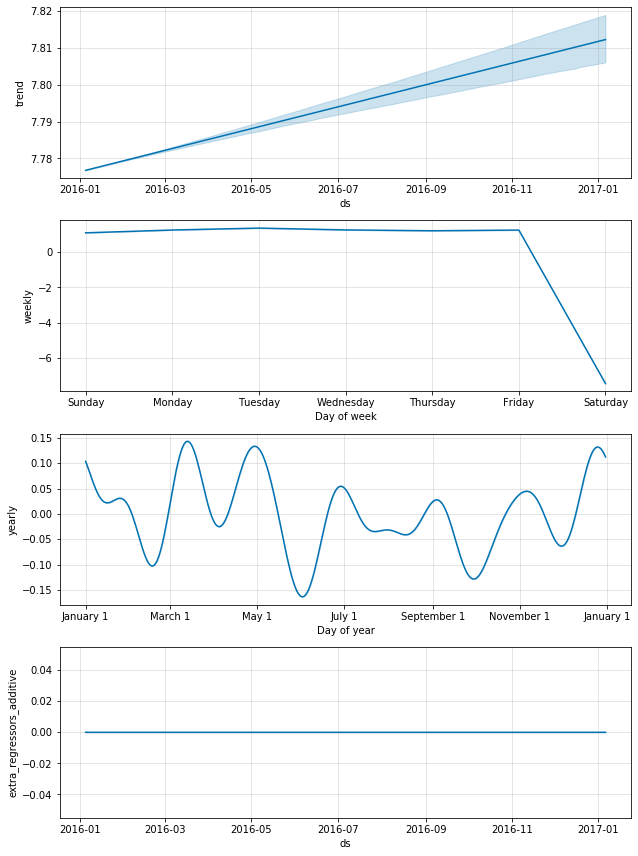

In [57]:
model.plot_components(forecast);

From these plots, we see that the trend is an increase in the order demand, as observed in the exploratory analysis of the data. From the weekly seasonality, we see a similar behavior as observed in the exploratory analysis as well, with high order demands from Sunday to Thursday.  The yearly seasonality, on the order hand, shows a good variation of order demand according to the month of the year. Finally, it seems that the additional regressor, added for the warehouse, it's not affecting the model.

In [58]:
rmse = root_mean_squared_error(y_true=test['Order_Demand'], y_pred=forecast['yhat'])
print(f'RMSE : {rmse:.2f}')

RMSE : 1.52


Here, we see that the achieve RMSE is a little bit better than using a XGB Regressor. 

Finally, we can take a look at the predictions for the test set:

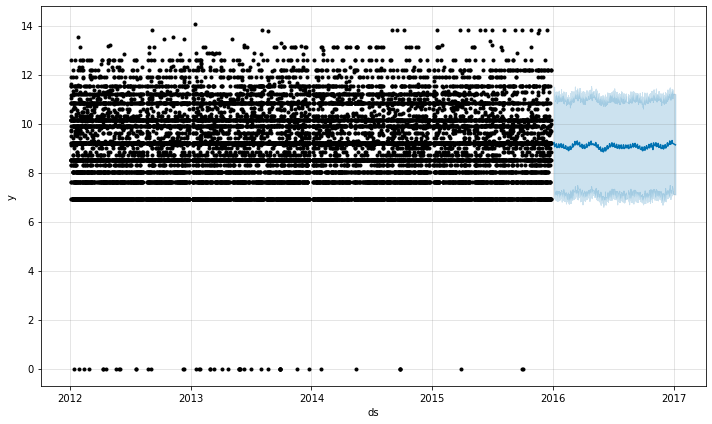

In [59]:
model.plot(forecast);

### Dependencies

In [60]:
import types

def imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            yield val.__name__

excludes = ['builtins', 'types', 'sys']

imported_modules = [module for module in imports() if module not in excludes]
clean_modules = []

for module in imported_modules:

    sep = '.'  # to handle 'matplotlib.pyplot' cases
    rest = module.split(sep, 1)[0]
    clean_modules.append(rest)

changed_imported_modules = list(set(clean_modules))  # drop duplicates

pip_modules = !pip3 freeze  # you could also use `!conda list` with anaconda
for module in pip_modules:
    name, version = module.split('==')
    if name in changed_imported_modules:
        print(name + '==' + version)

matplotlib==3.1.1
missingno==0.4.2
numpy==1.17.4
pandas==0.25.3
seaborn==0.9.0
xgboost==0.90
